In [2]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[1]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

# set font size 8
plt.rcParams.update({'font.size': 9})

In [3]:
def fetch_tc_fit_params(db_path, selected_construct, selected_site_base, selected_valtype_tc = 'modrate'):
    """
    Fetch fitted time-course parameters for a specific rg_id, site_base, and valtype.
    
    Parameters
    ----------
    db_path : str
        Path to the SQLite database file.
    selected_construct : str
        Construct disp_name
    selected_site_base : str
        Site and base combination (e.g., '18_A', '25_C').
    selected_valtype_tc : str
        Value type for filtering (e.g., 'modrate').

    Returns
    -------
    pd.DataFrame
        DataFrame containing fitted parameters with columns: fit_run_id, log_kobs,
        log_kdeg, log_fmod0, kobs, kdeg, fmod0, log_kobs_err, log_kdeg_err,
        log_fmod0_err, diag_r2.
    """

    conn = sqlite3.connect(db_path)
    fitted_params_df = pd.read_sql_query(
        """
        WITH run AS (
            SELECT id AS fit_run_id, rg_id
            FROM probe_tc_fit_runs
            WHERE (rg_id, nt_id) IN (
                SELECT DISTINCT pr.rg_id, mn.id
                FROM probe_reactions pr
                JOIN probe_fmod_values fv ON fv.rxn_id = pr.id
                JOIN meta_nucleotides mn ON mn.id = fv.nt_id
                JOIN meta_constructs mc ON mc.id = pr.construct_id
                WHERE mc.disp_name = :selected_construct
                AND mn.site || '_' || UPPER(mn.base) = :site_base
            )
            AND fit_kind = 'round3_constrained'
            AND valtype = :valtype_mod
        )
        SELECT
            p.fit_run_id,
            r.rg_id,
            pr.temperature,
            pr.replicate,
            MAX(CASE WHEN p.param_name IN ('log_kobs','logkobs')
                    THEN p.param_numeric END) AS log_kappa,
            MAX(CASE WHEN p.param_name IN ('log_kdeg','logkdeg')
                    THEN p.param_numeric END) AS log_kdeg,
            MAX(CASE WHEN p.param_name IN ('log_fmod0','logfmod0')
                    THEN p.param_numeric END) AS log_fmod0,
            MAX(CASE WHEN p.param_name IN ('log_kobs_err','logkobs_err')
                    THEN p.param_numeric END) AS log_kappa_err,
            MAX(CASE WHEN p.param_name IN ('log_kdeg_err','logkdeg_err')
                    THEN p.param_numeric END) AS log_kdeg_err,
            MAX(CASE WHEN p.param_name IN ('log_fmod0_err','logfmod0_err')
                    THEN p.param_numeric END) AS log_fmod0_err,
            MAX(CASE WHEN p.param_name = 'diag:r2'
                    THEN p.param_numeric END) AS r2
        FROM probe_tc_fit_params p
        JOIN run r
            ON r.fit_run_id = p.fit_run_id
        JOIN probe_reactions pr
            ON pr.rg_id = r.rg_id
        GROUP BY
            p.fit_run_id,
            r.rg_id,
            pr.temperature,
            pr.replicate
        ORDER BY
            pr.temperature ASC,
            pr.replicate ASC;
        """,
        conn,
        params={"selected_construct": selected_construct, "site_base": selected_site_base, "valtype_mod": selected_valtype_tc},
    )
    conn.close()
    return fitted_params_df

In [4]:
def mean_with_error(df, value_col='value', err_col='err'):
    """
    Compute an unweighted mean and its propagated uncertainty.

    Mean is the simple arithmetic average.
    Error propagation for averaging N independent values:
        err_mean = sqrt(sum(err_i^2)) / N

    Parameters
    ----------
    df : pandas.DataFrame
        Must contain `value_col` and `err_col`.
    value_col : str, default 'value'
        Column containing measured values.
    err_col : str, default 'err'
        Column containing 1σ uncertainties for each value.

    Returns
    -------
    mean : float
        Simple arithmetic mean.
    err_mean : float
        Propagated uncertainty on the mean.
    n : int
        Number of points used (after dropping NaNs).
    """
    # Drop missing values
    df = df.dropna(subset=[value_col, err_col]).copy()
    n = len(df)
    if n == 0:
        return np.nan, np.nan, 0

    # Simple mean
    mean = df[value_col].mean()

    # Propagated error on the mean
    err_mean = np.sqrt((df[err_col] ** 2).sum()) / n

    return mean, err_mean, n

def calc_dG(lnkobs, lnkobs_err, lnkadd, lnkadd_err, temp, ignore_lnkadd_err = False):
    # kobs = K/(K+1)kadd
    # dG = -RT ln(K)

    lnKKp1 = lnkobs - lnkadd
    lnKKp1_err = np.sqrt(lnkobs_err**2 + lnkadd_err**2)

    if ignore_lnkadd_err:
        lnKKp1_err = lnkobs_err

    KKp1 = np.exp(lnKKp1)
    KKp1_err = KKp1 * lnKKp1_err
    K = KKp1 / (1 - KKp1)
    K_err = KKp1_err / (1 - KKp1)**2
    dG = -(sc.R / sc.calorie / 1000) * (temp + 273.15) * np.log(K)
    dG_err = (sc.R / sc.calorie / 1000) * (temp + 273.15) / K * K_err
    dG_err = np.abs(dG_err)

    return dG, dG_err, KKp1, KKp1_err

In [5]:
# Calculate kinetic parameters at a given temp

temp_C = 25.0
conc_DMS = 0.015852692  # in M, 1.5% v/v

# Load ln(kadd) Arrhenius fits
lnkadd_A_linfit = load_modelresult('../HIV_Aggregated_Arrhenius/Arrhenius_fit_results/agg_HIV_A_arrhenius_fit.sav')
lnkadd_C_linfit = load_modelresult('../HIV_Aggregated_Arrhenius/Arrhenius_fit_results/agg_HIV_C_arrhenius_fit.sav')
lnkadd_linfits = {'A': lnkadd_A_linfit,
                  'C': lnkadd_C_linfit}
#sites_dict = {'C': [19, 24, 29, 30, 37, 39, 41, 44, 45], 'A': [2, 3, 20, 22, 27, 35, 61, 62]}

to_fit = {'hiv_wt': ['2_A', '3_A', '19_C', '20_A', '22_A', '24_C', '27_A', '29_C', '30_C', '35_A', '37_C', '39_C', '41_C', '44_C', '45_C', '61_A', '62_A'],
          'hiv_a35g': ['2_A', '3_A', '19_C', '20_A', '22_A', '24_C', '27_A', '29_C', '30_C', '35_A', '37_C', '39_C', '41_C', '44_C', '45_C', '61_A', '62_A'],
          'hiv_c30u': ['2_A', '3_A', '19_C', '20_A', '22_A', '24_C', '27_A', '29_C', '30_C', '35_A', '37_C', '39_C', '41_C', '44_C', '45_C', '61_A', '62_A'],
          'hiv_gs': ['2_A', '3_A', '19_C', '20_A', '22_A', '24_C', '27_A', '29_C', '30_C', '35_A', '37_C', '39_C', '41_C', '44_C', '45_C', '61_A', '62_A'],
          'hiv_es2': ['2_A', '3_A', '19_C', '20_A', '22_A', '24_C', '27_A', '29_C', '30_C', '35_A', '37_C', '39_C', '41_C', '44_C', '45_C', '61_A', '62_A']
          }

construct = 'hiv_gs'
site = '27_A'


# Calculate kinetic parameters at temp_C
rows = []
for construct, sites in to_fit.items():
    for site in sites:

        lnkadd_linfit = lnkadd_linfits[site.split('_')[1]]  # select A or C fit
        # calculate kadd and kadd_err at 25C
        ln_kadd = lnkadd_linfit.eval(x = 1/(temp_C + 273.15)) + np.log(conc_DMS)
        ln_kadd_err = lnkadd_linfit.eval_uncertainty(x = 1/(temp_C + 273.15))

        # Extracting actual data points for A18 due to failure to fit to 2-state model
        tc_fit = fetch_tc_fit_params(NERD_SQLITE, construct, site, selected_valtype_tc = 'modrate')

        # Filter R2 > 0.3
        tc_fit = tc_fit[tc_fit['r2'] > 0.3].copy()

        # drop na
        tc_fit = tc_fit.dropna(subset=['log_kappa', 'log_kdeg', 'log_kappa_err', 'log_kdeg_err']).copy()
        tc_fit['ln_kobs'] = tc_fit['log_kappa'] + tc_fit['log_kdeg']
        tc_fit['ln_kobs_err'] = np.sqrt(tc_fit['log_kappa_err']**2 + tc_fit['log_kdeg_err']**2)
        tc_fit_25C = tc_fit[tc_fit['temperature'] == 25]
        # calculate mean and propagate error across replicates for ln_kobs, ln_kobs_err
        ln_kobs_mean_wt, ln_kobs_mean_err_wt, n_wt = mean_with_error(tc_fit_25C, value_col = 'ln_kobs', err_col = 'ln_kobs_err')
        dG, dG_err, KKp1, KKp1_err = calc_dG(ln_kobs_mean_wt, ln_kobs_mean_err_wt, ln_kadd, ln_kadd_err, temp_C, True)

        # save in this format: construct,site,temp_C,ln_kobs,ln_kobs_err,ln_kadd,ln_kadd_err,n,site_num,dG,dG_err
        site_num = int(site.split('_')[0])
        rows.append({'construct': construct,
                     'site': site,
                     'temp_C': temp_C,
                     'ln_kobs': ln_kobs_mean_wt,
                     'ln_kobs_err': ln_kobs_mean_err_wt,
                     'ln_kadd': ln_kadd,
                     'ln_kadd_err': ln_kadd_err,
                     'n': n_wt,
                     'site_num': site_num,
                     'dG': dG,
                     'dG_err': dG_err
                     })
hiv_dG_df = pd.DataFrame(rows).dropna()
hiv_dG_df.to_csv('hiv_dG_values_25C.csv', index=False)

In [6]:
def plot_hiv_variant_dG(hiv_dG_df, variant, site_num_to_plot,
                        vmin=-2.0, vmax=4.0, xticklabels=None, ax=None):
    """
    Plot ΔG_DMS for a single HIV variant across specified site numbers.

    Parameters
    ----------
    hiv_dG_df : DataFrame
    variant : str
        Construct name (e.g., "hiv_wt")
    site_num_to_plot : list of int
        Sites in desired x-axis order
    vmin, vmax : float
        Colorbar limits
    xticklabels : list of str, optional
        Custom tick labels matching site_num_to_plot order
    ax : matplotlib axis, optional
    """

    # Colormap
    colors = ["#0f4c5c", "#ecf39e", "#9a031e"]
    custom_cmap = LinearSegmentedColormap.from_list("teal_gold_red", colors)

    # Subset to variant
    df = hiv_dG_df[hiv_dG_df["construct"] == variant].copy()

    # Use site_num for alignment
    df = df.set_index("site_num")

    # Add missing site_num rows
    missing = set(site_num_to_plot) - set(df.index)
    if missing:
        df_missing = pd.DataFrame(
            {"site_num": list(missing),
             "construct": variant,
             "dG": np.nan, "dG_err": np.nan}
        ).set_index("site_num")

        # match all existing columns
        for col in df.columns:
            if col not in df_missing.columns:
                df_missing[col] = np.nan

        df = pd.concat([df, df_missing], axis=0)

    # Reindex to sorted input list
    df = df.reindex(site_num_to_plot).reset_index()

    # X positions
    x = np.arange(len(df))

    # Colors
    vals = df["dG"].values
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    bar_colors = custom_cmap(norm(vals))

    # Axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.5, 1.8))
    else:
        fig = ax.figure

    # Bars
    ax.bar(
        x, df["dG"],
        yerr=df["dG_err"],
        width=0.8,
        color=bar_colors,
        edgecolor="black",
        capsize=2,
        error_kw=dict(lw=1, capthick=1),
        zorder=2,
    )

    # Horizontal line at y=0
    ax.axhline(0, color="black", lw=0.5, ls="-", zorder=1)

    # ----- X Tick Labels -----
    if xticklabels is not None:
        # Use user-provided labels
        ax.set_xticks(x)
        ax.set_xticklabels(xticklabels, rotation=45)
    else:
        # Auto: use site+base if available
        if "site" in df.columns:
            default_labels = df["site"].tolist()
        else:
            default_labels = df["site_num"].astype(str).tolist()

        ax.set_xticks(x)
        ax.set_xticklabels(default_labels, rotation=45)

    # Axis formatting
    ax.set_ylim(vmin, vmax)
    ax.set_ylabel(r"$\Delta G^{\circ}_{\mathrm{DMS}}$ (kcal/mol)")

    plt.tight_layout()
    return fig, ax

In [7]:
os.makedirs('dG_barplots', exist_ok=True)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


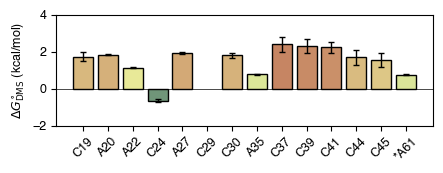

In [8]:
site_num_to_plot = [19, 20, 22, 24, 27, 29, 30, 35, 37, 39, 41, 44, 45, 61]
ticklabels = ['C19', 'A20', 'A22', 'C24', 'A27', 'C29', 'C30', 'A35', 'C37', 'C39', 'C41', 'C44', 'C45', '*A61']

fig, ax = plot_hiv_variant_dG(hiv_dG_df, 'hiv_wt', site_num_to_plot, vmin=-2.0, vmax=4.0, xticklabels=ticklabels)
plt.savefig('dG_barplots/hiv_wt_dG_barplot_25C.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


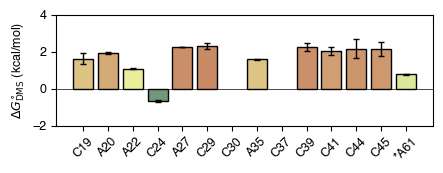

In [9]:
fig, ax = plot_hiv_variant_dG(hiv_dG_df, 'hiv_c30u', site_num_to_plot, vmin=-2.0, vmax=4.0, xticklabels=ticklabels)
plt.savefig('dG_barplots/hiv_c30u_dG_barplot_25C.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


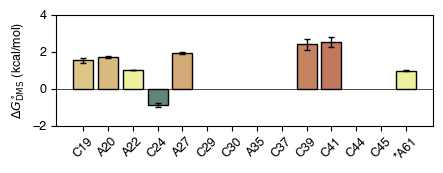

In [10]:
fig, ax = plot_hiv_variant_dG(hiv_dG_df, 'hiv_a35g', site_num_to_plot, vmin=-2.0, vmax=4.0, xticklabels=ticklabels)
plt.savefig('dG_barplots/hiv_a35g_dG_barplot_25C.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


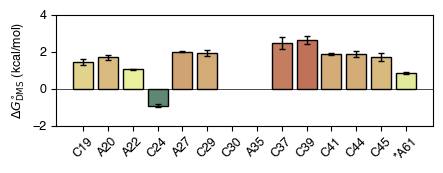

In [11]:
fig, ax = plot_hiv_variant_dG(hiv_dG_df, 'hiv_gs', site_num_to_plot, vmin=-2.0, vmax=4.0, xticklabels=ticklabels)
plt.savefig('dG_barplots/hiv_gs_dG_barplot_25C.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


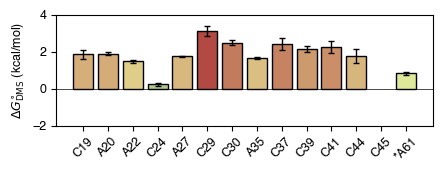

In [12]:
fig, ax = plot_hiv_variant_dG(hiv_dG_df, 'hiv_es2', site_num_to_plot, vmin=-2.0, vmax=4.0, xticklabels=ticklabels)
plt.savefig('dG_barplots/hiv_es2_dG_barplot_25C.pdf')

In [13]:
## ddG

def compute_ddG_vs_wt(df, wt_name="hiv_wt"):
    """
    Compute ddG (variant - wt) and ddG_err for each construct at each site.

    Parameters
    ----------
    df : DataFrame
        Must contain columns: construct, site, site_num, dG, dG_err.
    wt_name : str
        Name of the WT construct.

    Returns
    -------
    DataFrame
        Columns: site, site_num, construct, ddG, ddG_err
    """

    # isolate WT rows
    df_wt = df[df["construct"] == wt_name][["site", "site_num", "dG", "dG_err"]]
    df_wt = df_wt.rename(columns={"dG": "dG_wt", "dG_err": "dG_err_wt"})

    # merge WT values onto full df (variant rows will get WT matched by site)
    merged = pd.merge(df, df_wt, on=["site", "site_num"], how="inner")

    # drop WT itself from comparisons
    merged = merged[merged["construct"] != wt_name]

    # compute ddG and error propagation
    merged["ddG"] = merged["dG"] - merged["dG_wt"]
    merged["ddG_err"] = np.sqrt(merged["dG_err"]**2 + merged["dG_err_wt"]**2)

    # final tidy columns
    out = merged[["site", "site_num", "construct", "ddG", "ddG_err"]].sort_values(
        by=["site_num", "construct"]
    )

    return out

hiv_ddG_df = compute_ddG_vs_wt(hiv_dG_df, wt_name="hiv_wt")
hiv_ddG_df.to_csv('hiv_ddG_vs_wt_25C.csv', index=False)

In [14]:
def plot_hiv_variant_ddG(ddG_df, variant, site_num_to_plot,
                         vmin=-2.0, vmax=4.0, xticklabels=None, ax=None):
    """
    Plot ΔΔG = (variant - WT) for a single HIV variant across specified sites.

    Parameters
    ----------
    ddG_df : DataFrame
        Must contain columns: construct, site, site_num, ddG, ddG_err
    variant : str
        Variant name (e.g., "hiv_a35g")
    site_num_to_plot : list of int
        Ordered sites for the x-axis
    vmin, vmax : float
        Y-axis range
    xticklabels : list of str, optional
        Custom tick labels matching site_num_to_plot
    ax : matplotlib axis, optional
    """

    # Subset to variant
    df = ddG_df[ddG_df["construct"] == variant].copy()

    # Use site_num for alignment
    df = df.set_index("site_num")

    # Add missing site_num rows
    missing = set(site_num_to_plot) - set(df.index)
    if missing:
        df_missing = pd.DataFrame(
            {"site_num": list(missing),
             "construct": variant,
             "ddG": np.nan, "ddG_err": np.nan}
        ).set_index("site_num")

        # match any extra cols
        for col in df.columns:
            if col not in df_missing.columns:
                df_missing[col] = np.nan

        df = pd.concat([df, df_missing], axis=0)

    # Reindex to the requested order
    df = df.reindex(site_num_to_plot).reset_index()

    # X positions
    x = np.arange(len(df))

    # Axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.5, 1.8))
    else:
        fig = ax.figure

    # Bars — all light gray
    ax.bar(
        x, df["ddG"],
        yerr=df["ddG_err"],
        width=0.8,
        color="lightgray",
        edgecolor="black",
        capsize=2,
        error_kw=dict(lw=1, capthick=1),
        zorder=2,
    )

    # horizontal line at y=0
    ax.axhline(0, color="black", lw=0.5, ls="-", zorder=1)

    # X Tick Labels
    if xticklabels is not None:
        ax.set_xticks(x)
        ax.set_xticklabels(xticklabels, rotation=45)
    else:
        if "site" in df.columns:
            default_labels = df["site"].tolist()
        else:
            default_labels = df["site_num"].astype(str).tolist()

        ax.set_xticks(x)
        ax.set_xticklabels(default_labels, rotation=45)

    # Axis formatting
    ax.set_ylim(vmin, vmax)
    ax.set_ylabel(r"$\Delta \Delta G^{\circ}_{\mathrm{DMS}}$ (kcal/mol)")

    plt.tight_layout()
    return fig, ax

In [15]:
os.makedirs('ddG_barplots', exist_ok=True)

In [16]:
hiv_ddG_df

,site,site_num,construct,ddG,ddG_err
13,19_C,19,hiv_a35g,-0.187979,0.266957
21,19_C,19,hiv_c30u,-0.118761,0.373248
43,19_C,19,hiv_es2,0.121125,0.336748
32,19_C,19,hiv_gs,-0.311295,0.280635
14,20_A,20,hiv_a35g,-0.128679,0.081893
22,20_A,20,hiv_c30u,0.088949,0.067349
44,20_A,20,hiv_es2,0.041730,0.082803
33,20_A,20,hiv_gs,-0.141241,0.138210
15,22_A,22,hiv_a35g,-0.114257,0.027046
23,22_A,22,hiv_c30u,-0.055382,0.028887


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


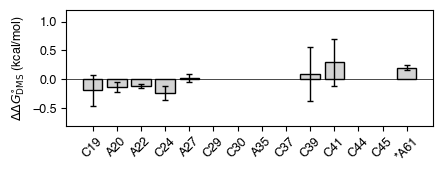

In [17]:
site_num_to_plot = [19, 20, 22, 24, 27, 29, 30, 35, 37, 39, 41, 44, 45, 61]
ticklabels = ['C19', 'A20', 'A22', 'C24', 'A27', 'C29', 'C30', 'A35', 'C37', 'C39', 'C41', 'C44', 'C45', '*A61']

fig, ax = plot_hiv_variant_ddG(hiv_ddG_df, 'hiv_a35g', site_num_to_plot, vmin=-0.8, vmax=1.2, xticklabels=ticklabels)
plt.savefig('ddG_barplots/hiv_a35g_ddG_barplot_25C.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


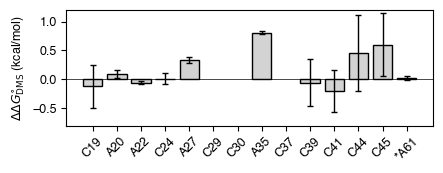

In [18]:
fig, ax = plot_hiv_variant_ddG(hiv_ddG_df, 'hiv_c30u', site_num_to_plot, vmin=-0.8, vmax=1.2, xticklabels=ticklabels)
plt.savefig('ddG_barplots/hiv_c30u_ddG_barplot_25C.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


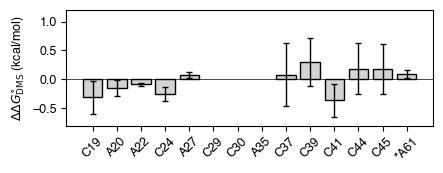

In [19]:
fig, ax = plot_hiv_variant_ddG(hiv_ddG_df, 'hiv_gs', site_num_to_plot, vmin=-0.8, vmax=1.2, xticklabels=ticklabels)
plt.savefig('ddG_barplots/hiv_gs_ddG_barplot_25C.pdf')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


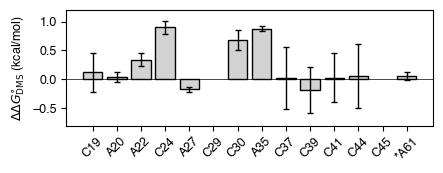

In [20]:
fig, ax = plot_hiv_variant_ddG(hiv_ddG_df, 'hiv_es2', site_num_to_plot, vmin=-0.8, vmax=1.2, xticklabels=ticklabels)
plt.savefig('ddG_barplots/hiv_es2_ddG_barplot_25C.pdf')